In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import pandas as pd

import random
import keras
from sklearn import metrics
#!pip install peakutils
#import peakutils
from sklearn.utils import shuffle
import tensorflow as tf
from scipy.interpolate import *
from scipy.signal import *
from sklearn.model_selection import train_test_split

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
! git clone https://github.com/vishnurmurthy/Myocardial_Ischemia_Detection
!ls

large_data = pd.DataFrame({"Signal":[], "Label":[]})
large_data

datafiles = ['s20011.xz','s20131.xz','s20251.xz','s20341.xz','s20471.xz','s20591.xz','s30721.xz','s20021.xz','s20141.xz',
's20351.xz','s20481.xz','s20601.xz','s30731.xz','s20031.xz','s20151.xz','s20271.xz','s20361.xz','s20491.xz','s20621.xz',
's20272.xz','s20371.xz','s20501.xz','s20431.xz','s20551.xz','s20181.xz','s30661.xz','s20301.xz','s20231.xz','s20321.xz',
's20631.xz','s30741.xz','s20051.xz','s20171.xz','s20273.xz','s20381.xz','s20511.xz','s20641.xz','s30742.xz','s20061.xz',
's20274.xz','s20391.xz','s20521.xz','s20651.xz','s30751.xz','s20071.xz','s20191.xz','s20281.xz','s20401.xz','s20531.xz',
's30752.xz','s20081.xz','s20201.xz','s20291.xz','s20411.xz','s20541.xz','s30671.xz','s30761.xz','s20091.xz','s20211.xz',
's30681.xz','s30771.xz','s20101.xz','s20221.xz','s20311.xz','s20441.xz','s20561.xz','s30691.xz','s30781.xz','s20111.xz',
's20451.xz','s20571.xz','s30701.xz','s30791.xz','s20121.xz','s20241.xz','s20331.xz','s20461.xz','s20581.xz','s30711.xz', 
's30732.xz','s20041.xz','s20161.xz','s30801.xz', 's20261.xz',]

os.chdir('Myocardial_Ischemia_Detection/')
!ls


fatal: destination path 'Myocardial_Ischemia_Detection' already exists and is not an empty directory.
Model_example.ipynb           Model_example_v4.ipynb
Model_example_v2.ipynb        Myocardial_Ischemia_Detection
Model_example_v3.ipynb
Myocardial_Ischemia_Detection processed_data
README.md                     raw_data
machine_learning_model        scripts
preprocessing


In [ ]:
os.chdir('processed_data')
for i in datafiles:
  dat = pd.read_pickle(i)
  for count, signal in enumerate(dat['Signal']):
    dat['Signal'][count] = dat['Signal'][count] - np.mean(dat['Signal'][count])
    dat['Signal'][count] = dat['Signal'][count] / np.std(dat['Signal'][count])
  large_data = large_data.append(dat)
os.chdir('../..')

# of data rows for ST:  298287
# of data rows for RTST:  86628
# of data rows for Normal:  290985
nx 0


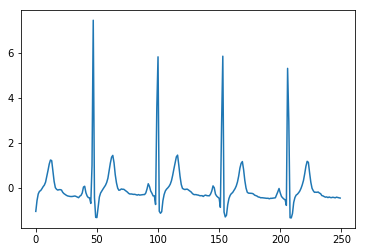

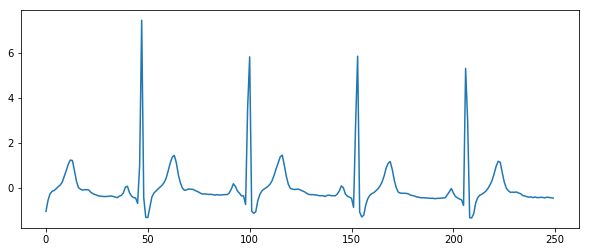

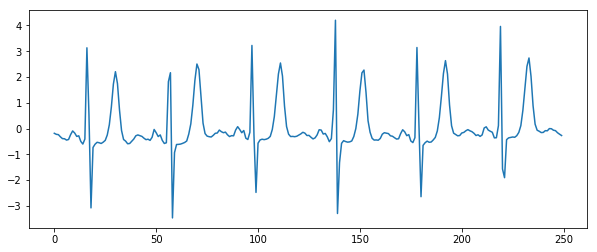

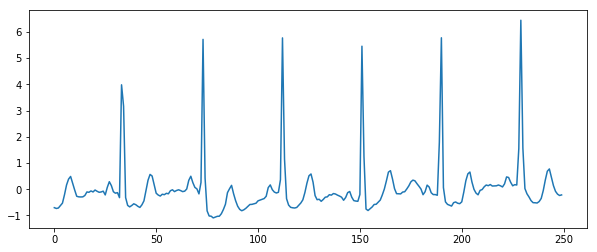

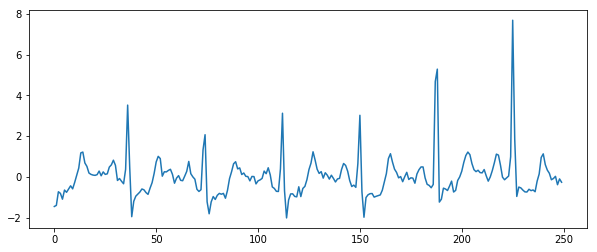

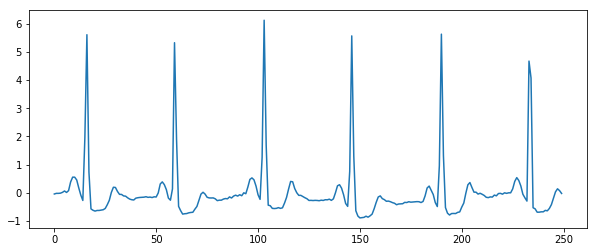

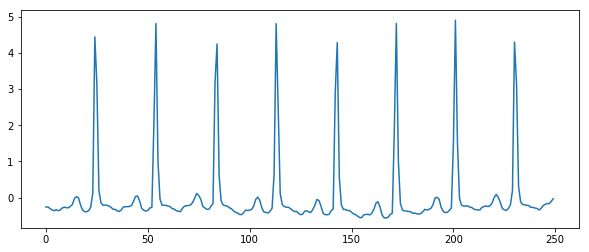

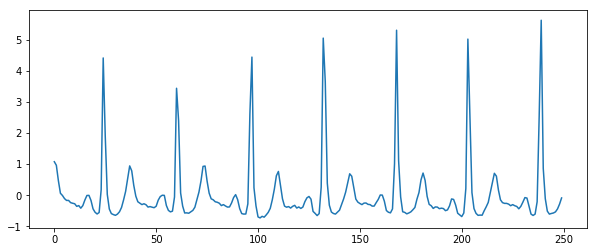

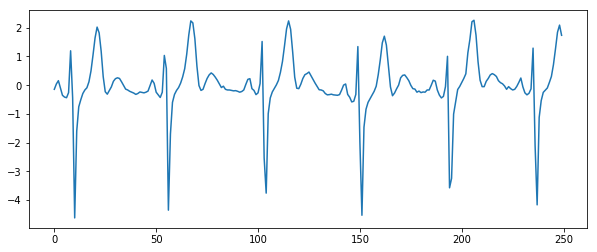

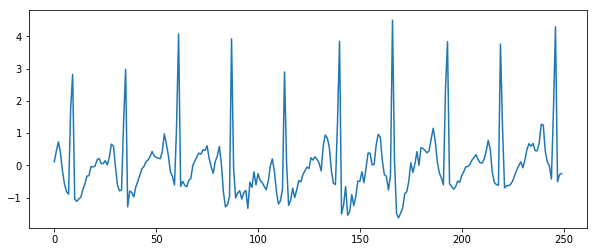

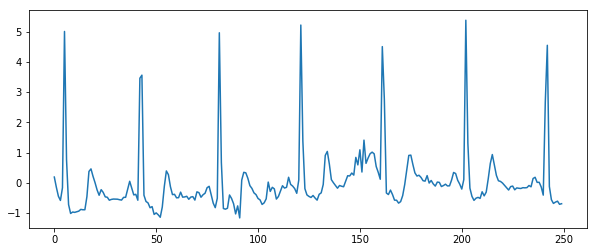

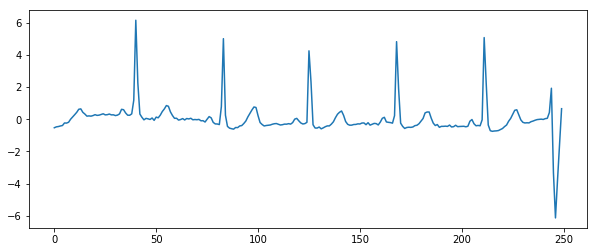

In [8]:
large_data = large_data[large_data.Label != 'scct'] #dropping rows with shifts, we are not classifying
large_data = large_data[large_data.Label != 'sst']

large_data['Label'] = large_data['Label'].map({'st': 0, 'rtst': 1, 'normal': 2})

print("# of data rows for ST: ", len(large_data.loc[large_data['Label'] == 0]))
print("# of data rows for RTST: ", len(large_data.loc[large_data['Label'] == 1]))
print("# of data rows for Normal: ", len(large_data.loc[large_data['Label'] == 2]))

newx = 0
for i in large_data['Signal']:
	if len(i)!= 250:
		print(len(i))
		newx+=1
print("nx", newx)

#convert to ints

large_data['Label'] = large_data['Label'].astype('category').cat.codes

#randomly shuffle dataframe

large_data = large_data.sample(frac=1).reset_index(drop=True)

plt.plot(np.arange(0, 250), large_data['Signal'][0])

LEN = large_data.shape[0]

for i in range(0, 676483, 67000):
    plt.figure(figsize = (10, 4))
    plt.plot(np.arange(0, 250), large_data['Signal'][i])
    plt.show()

In [9]:
y = large_data['Label'].values
X = []
for i in large_data['Signal']:
    X.append(i)
X = np.array(X)

print("Y")
print(y.shape)
print("X")
print(X.shape)

Y
(676484,)
X
(676484, 250)


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

y_train = tf.keras.utils.to_categorical(y_train, 3)
y_train = y_train.astype(np.float32)
y_val = tf.keras.utils.to_categorical(y_val, 3)
y_val = y_val.astype(np.float32)

#X_train = X_train.astype(np.float32)
#X_val = X_val.astype(np.float32)

print("Training")
print(X_train.shape, y_train.shape)
print("Validation")
print(X_val.shape, y_val.shape)

Training
(541187, 250) (541187, 3)
Validation
(135297, 250) (135297, 3)


In [13]:
def ConvBlock(model, layers):
    for i in range(layers):
        model.add(tf.keras.layers.Conv1D(16, 6, activation = 'relu', padding = 'valid'))
        model.add(tf.keras.layers.MaxPooling1D(2, strides=2))
        model.add(tf.keras.layers.Dropout(.25))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    
def DenseBlock(model, layers, neurons = None):
    for i in range(layers):
        model.add(tf.keras.layers.Dense(neurons[i], activation = 'relu'))
        model.add(tf.keras.layers.Dropout(.25))
    model.add(tf.keras.layers.Flatten())
        

In [14]:
model = tf.keras.models.Sequential()
'''
model.add(tf.keras.layers.Dense(128, activation='relu', input_shape = X_train[0].shape))
model.add(tf.keras.layers.GaussianDropout(.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.GaussianDropout(.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.GaussianDropout(.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.GaussianDropout(.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
'''
model.add(tf.keras.layers.InputLayer(input_shape = (X_train[0].shape[0], 1)))

ConvBlock(model, 3)

DenseBlock(model, 3, (128, 64, 32))

model.add(tf.keras.layers.Dense(32, activation = 'relu'))
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=0.001), metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 245, 16)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 122, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 122, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 117, 16)           1552      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 58, 16)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 58, 16)            0         
__________

In [15]:
print(X_train[0].shape)

(250,)


In [16]:
################################################################
############## RUN ONLY FOR CONVOLUTION 1D MODELS ##############
################################################################

X_train = X_train.reshape(len(X_train), X_train[0].shape[0], 1)
X_val = X_val.reshape(len(X_val), X_val[0].shape[0], 1)

################################################################
############## RUN ONLY FOR CONVOLUTION 1D MODELS ##############
################################################################

In [ ]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), verbose = True, epochs=5)

In [78]:
test_pred = pd.DataFrame(model.predict(X_val))
test_predict = test_pred.idxmax(axis=1)
test_labels = [ np.where(label==1)[0][0] for label in y_val]
test_labels_one_hot = pd.DataFrame(y_val)
test_pred.head(5)

,0,1,2
0,0.544149,0.115061,0.340789
1,0.000778,0.955360,0.043863
2,0.420025,0.083433,0.496542
3,0.567776,0.107429,0.324794
4,0.897892,0.012563,0.089546


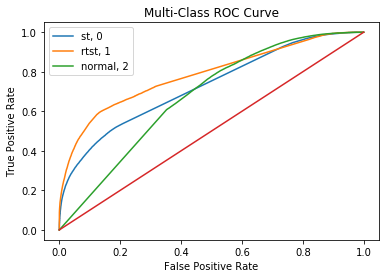

In [80]:
fpr = {}
tpr = {}
roc_auc = {}
stage_dict = ['st', 'rtst', 'normal']
for i in range(3):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_labels_one_hot.iloc[:, i], test_pred.iloc[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = stage_dict[i] + ', ' + str(i))
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()

fpr["micro"], tpr["micro"], _ = metrics.roc_curve(test_labels_one_hot.values.ravel(), test_pred.values.ravel())
roc_auc = metrics.auc(fpr["micro"], tpr["micro"])

ROC:  0.7886724722327327
ACC:  0.5959777378655846
[[0.22861556 0.00241691 0.20703342]
 [0.02090216 0.0337258  0.07545622]
 [0.08622512 0.01198844 0.33363637]]


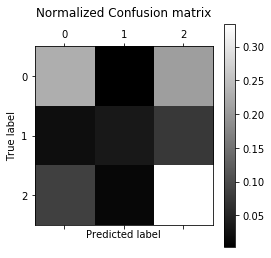

[[30931   327 28011]
 [ 2828  4563 10209]
 [11666  1622 45140]]


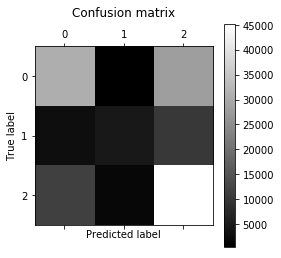

In [82]:
print("ROC: ", roc_auc)
print("ACC: ", metrics.accuracy_score(test_labels, test_predict))
cm = metrics.confusion_matrix(test_labels, test_predict)

'''
ROC:  0.8388993698385805
ACC:  0.6494009475450305
'''

print(cm/len(test_labels))
# Show confusion matrix in a separate window
plt.matshow(cm/len(test_labels), cmap='gray')

plt.title('Normalized Confusion matrix\n')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(cm)

plt.matshow(cm, cmap='gray')

plt.title('Confusion matrix\n')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [85]:
#Save the model

model.save("BWSI2018.h5")

#Delete existing model

#del model

#Load the model

#model = load_model('my_model.h5')